In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Daily_electricity_consumption.csv')
df.head()

,date_time,active_power_consumed,meter_reading
0,01-01-2009,0.976869,1.946528
1,02-01-2009,1.616326,8.222917
2,03-01-2009,1.328817,7.249306
3,04-01-2009,1.347218,2.253472
4,05-01-2009,1.113889,6.006944


In [4]:
df.tail()

,date_time,active_power_consumed,meter_reading
690,22-11-2010,1.417733,7.038889
691,23-11-2010,1.095511,5.285417
692,24-11-2010,1.247394,8.488889
693,25-11-2010,0.993864,3.522222
694,26-11-2010,1.178230,7.908947


In [5]:
df.shape

(695, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_time              695 non-null    object 
 1   active_power_consumed  695 non-null    float64
 2   meter_reading          695 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.4+ KB


In [8]:
df.isnull().sum()

date_time                0
active_power_consumed    0
meter_reading            0
dtype: int64

In [9]:
time = pd.date_range(start='1/1/2009',end='11/26/2010',freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop('date_time',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [10]:
len(time)

695

In [11]:
df.head()

,active_power_consumed,meter_reading
time_stamp,,
2009-01-01,0.976869,1.946528
2009-01-02,1.616326,8.222917
2009-01-03,1.328817,7.249306
2009-01-04,1.347218,2.253472
2009-01-05,1.113889,6.006944


In [12]:
df.tail()

,active_power_consumed,meter_reading
time_stamp,,
2010-11-22,1.417733,7.038889
2010-11-23,1.095511,5.285417
2010-11-24,1.247394,8.488889
2010-11-25,0.993864,3.522222
2010-11-26,1.178230,7.908947


In [13]:
df = df[['active_power_consumed']]

In [14]:
df

,active_power_consumed
time_stamp,
2009-01-01,0.976869
2009-01-02,1.616326
2009-01-03,1.328817
2009-01-04,1.347218
2009-01-05,1.113889
...,...
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394


In [15]:
plt.rcParams['figure.figsize'] = [15,8]

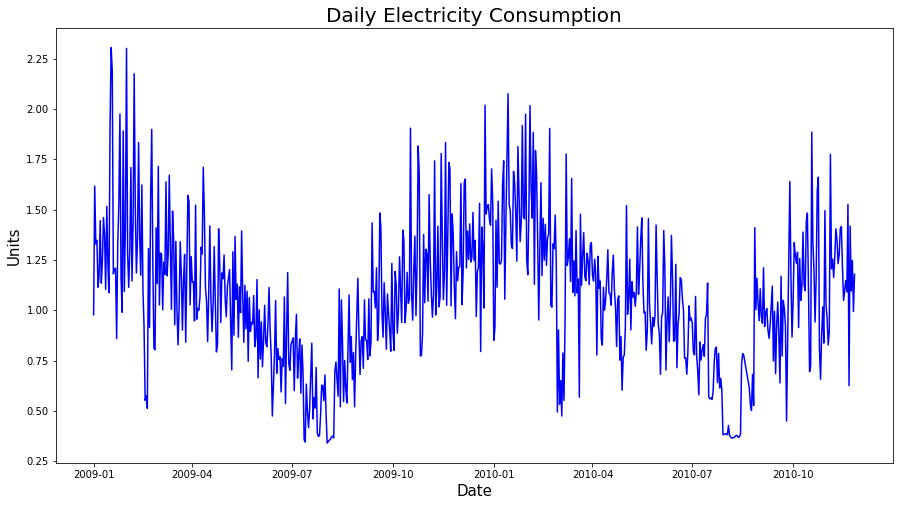

In [16]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [17]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [18]:
#Split data set into testing dataset and train dataset
train_size = 625
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 10
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(615, 10)
(615,)
(60, 10)
(60,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [21]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [23]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('first_rnn_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=8,max_value=128,step=8),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice(f"recurrent_dropout_{i}",[0.2,0.4,0.6],default=0.4)))
    model.add(SimpleRNN(hp.Int('final_rnn_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='elec_consum')

In [25]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
first_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
recurrent_dropout_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'defau

In [26]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 01s]
val_mape: 19.6481351852417

Best val_mape So Far: 17.40298366546631
Total elapsed time: 00h 27m 05s
INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.results_summary()

Results summary
Results in project/elec_consum
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_rnn_layer: 48
first_recurrent_dropout: 0.6
n_layers: 3
rnn_0_units: 56
recurrent_dropout_0: 0.6
final_rnn_layer: 96
last_recurrent_dropout: 0.2
dense_layer_1: 8
Dropout_rate: 0.4
learning_rate: 0.00177225433944805
rnn_1_units: 40
recurrent_dropout_1: 0.2
rnn_2_units: 24
recurrent_dropout_2: 0.6
rnn_3_units: 24
recurrent_dropout_3: 0.2
Score: 17.40298366546631
Trial summary
Hyperparameters:
first_rnn_layer: 64
first_recurrent_dropout: 0.2
n_layers: 2
rnn_0_units: 16
recurrent_dropout_0: 0.2
final_rnn_layer: 112
last_recurrent_dropout: 0.2
dense_layer_1: 80
Dropout_rate: 0.2
learning_rate: 0.001972612994637945
rnn_1_units: 8
recurrent_dropout_1: 0.4
Score: 18.50641918182373
Trial summary
Hyperparameters:
first_rnn_layer: 24
first_recurrent_dropout: 0.6
n_layers: 2
rnn_0_units: 120
recurrent_dropout_0: 0.6
final_rnn_layer: 40
last_recurrent

In [28]:
from warnings import filterwarnings
filterwarnings('ignore')

In [29]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 48)             2832      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 56)             5880      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 40)             3880      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1, 24)             1560      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 96)                11616     
                                                                 
 dense (Dense)               (None, 8)                 776       
                                                                 
 dropout (Dropout)           (None, 8)                 0

In [30]:
from tensorflow.keras import optimizers

In [50]:
model = Sequential()
model.add(SimpleRNN(48,activation='relu',input_shape=(1,look_back), return_sequences=True, recurrent_dropout = 0.6))
model.add(SimpleRNN(24,activation='relu', return_sequences=True, recurrent_dropout = 0.6))
model.add(SimpleRNN(96,activation='relu', recurrent_dropout = 0.6))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.00100225433944805)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 33, epochs = 200)

Epoch 1/200
19/19 [==============================] - 3s 32ms/step - loss: 58.0160 - mape: 58.0160 - val_loss: 41.1807 - val_mape: 41.1807
Epoch 2/200
19/19 [==============================] - 0s 6ms/step - loss: 44.5492 - mape: 44.5492 - val_loss: 31.2009 - val_mape: 31.2009
Epoch 3/200
19/19 [==============================] - 0s 6ms/step - loss: 40.2307 - mape: 40.2307 - val_loss: 25.7030 - val_mape: 25.7030
Epoch 4/200
19/19 [==============================] - 0s 6ms/step - loss: 37.7948 - mape: 37.7948 - val_loss: 22.5399 - val_mape: 22.5399
Epoch 5/200
19/19 [==============================] - 0s 6ms/step - loss: 35.8799 - mape: 35.8799 - val_loss: 25.1211 - val_mape: 25.1211
Epoch 6/200
19/19 [==============================] - 0s 7ms/step - loss: 33.4763 - mape: 33.4763 - val_loss: 22.8936 - val_mape: 22.8936
Epoch 7/200
19/19 [==============================] - 0s 6ms/step - loss: 35.3389 - mape: 35.3389 - val_loss: 23.1048 - val_mape: 23.1048
Epoch 8/200
19/19 [=====================

In [51]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE: 15.11
Test MAPE: 18.91


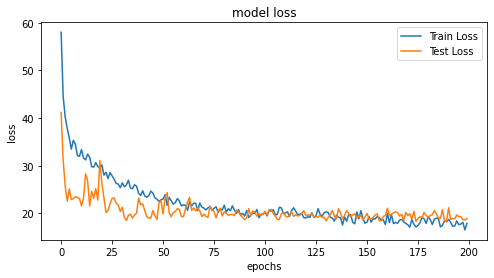

In [52]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train MAPE: %.2f' % ((train_score[1])))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test MAPE: %.2f' % (test_score[1]))
model_loss(model_history)

In [53]:
import seaborn as sns

In [54]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(615,675)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

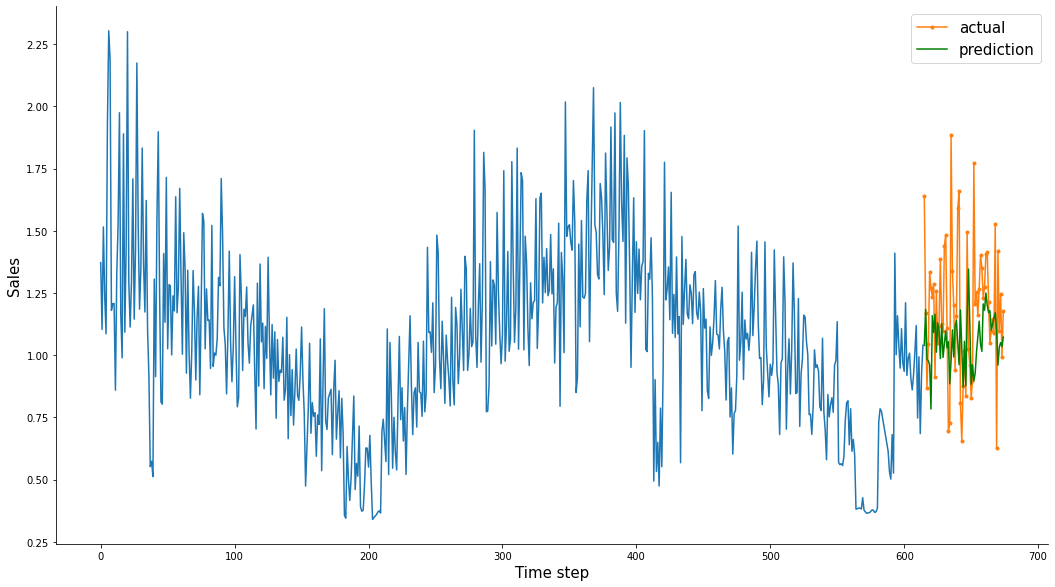

In [55]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)